##  Capstone Project - Predicting Car Accident Severity

### Applied Data Science Capstone by IBM/Coursera
#### Name: Yae Won Kim
#### Date: 27.Sep.2020

## Table of contents
1. [Introduction: Business Problem](#introduction)
2. [Dataset](#data)
3. [Analysis](#analysis)
4. [Methodology](#methodology)
5. [Results & Discussions](#results)
6. [Conclusion](#conclusion)

## Libraries used

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import imblearn
%matplotlib inline
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import collections, numpy
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn import metrics


## 1. Introduction: business problem <a name="introduction"></a>

The road accident not only interferes with traffic, but also leads to personal injury. It is important to prevent road accidents because serious accidents as well as minor accidents can kill people. With the development of technology, it is possible to predict the fatality of an accident by considering various factors such as weather and road conditions using machine learning technologies, so that the advancement of technology can contribute to preventing/predicting accidents. Furthermore, which of these factors has a greater influence on road accidents can be identified. Not only the government but also the general public can make their lives more prosperous by being provided with information related to traffic safety. In bad circumstances, the government can control traffic or warn drivers. Drivers can reschedule their trip or be aware of poor traffic conditions and pay more attention to driving.

## 2. Dataset <a name="data"></a>

The dataset to be used for this project is open data released by the Seattle Government, and contains all types of collisions data from 2004 to the present with 194,673 rows and 37 columns. All attributes are not considered, and only useful attributes will be used. This dataset contains data such as the severity of the collision based on the fatality and disabling injury counts, as well as how many people were injured in the accident. In addition, weather, road and light conditions are also recorded. It is checked whether there is any dupliacate record, but there is not duplicate record. 

In [2]:
# Import data with pandas
df = pd.read_csv("Data-Collisions.csv")

# Handle duplicate records
duplicate = df.duplicated()
duplicate.sum()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    194673 non-null  int64  
 1   X               189339 non-null  float64
 2   Y               189339 non-null  float64
 3   OBJECTID        194673 non-null  int64  
 4   INCKEY          194673 non-null  int64  
 5   COLDETKEY       194673 non-null  int64  
 6   REPORTNO        194673 non-null  object 
 7   STATUS          194673 non-null  object 
 8   ADDRTYPE        192747 non-null  object 
 9   INTKEY          65070 non-null   float64
 10  LOCATION        191996 non-null  object 
 11  EXCEPTRSNCODE   84811 non-null   object 
 12  EXCEPTRSNDESC   5638 non-null    object 
 13  SEVERITYCODE.1  194673 non-null  int64  
 14  SEVERITYDESC    194673 non-null  object 
 15  COLLISIONTYPE   189769 non-null  object 
 16  PERSONCOUNT     194673 non-null  int64  
 17  PEDCOUNT  

As it shows, we can identify there are different types of data such as numerical and categorical values here. There are 37 attributes here. However, we consider only some attributes for prediction. Selected attributes are

* **ADDRTYPE** - Collision address type (Alley, Block, Intersection)
* **JUNCTIONTYPE** - Category of junction at which collision took place
* **WEATHER** - A description of the weather conditions during the time of the collision.
* **ROADCOND** - The condition of the road during the collision.
* **LIGHTCOND** - The light conditions during the collision.
* **SPEEDING** - Whether or not speeding was a factor in the collision. (Y/N)

With those attributes, we will predict severity of collision.
* **SEVERITYCODE** - A code that corresponds to the severity of the collision

Severity code has four values:
- **0** means unknown
- **1** means damage
- **2** means injury
- **3** means fatality

Therefore, extract seven columns as a new dataframe.

In [4]:
# Extract columns
df = df[['ADDRTYPE', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'SEVERITYCODE.1']]
# Rename column name
df = df.rename(columns = {'SEVERITYCODE.1': 'SEVERITYCODE'})
# Check dataframe
df.head()

,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,SEVERITYCODE
0,Intersection,At Intersection (intersection related),Overcast,Wet,Daylight,NaN,2
1,Block,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,NaN,1
2,Block,Mid-Block (not related to intersection),Overcast,Dry,Daylight,NaN,1
3,Block,Mid-Block (not related to intersection),Clear,Dry,Daylight,NaN,1
4,Intersection,At Intersection (intersection related),Raining,Wet,Daylight,NaN,2


### 2.1 Data preprocessing <a name = 'datapre'></a>

Check data type for columns with .info().

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ADDRTYPE      192747 non-null  object
 1   JUNCTIONTYPE  188344 non-null  object
 2   WEATHER       189592 non-null  object
 3   ROADCOND      189661 non-null  object
 4   LIGHTCOND     189503 non-null  object
 5   SPEEDING      9333 non-null    object
 6   SEVERITYCODE  194673 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 10.4+ MB


`SEVERITYCODE` is integer, so make it categorical since other attributes are categorical here.

As this information shows, all columns except `SEVERITYCODE` column have a lot of null data. The six columns are categorical value, so we will impute with the most frequent level(value) of that variable for each attribute(column).

In [6]:
# ADDRTYPE
pd.DataFrame(df.ADDRTYPE.value_counts())

,ADDRTYPE
Block,126926
Intersection,65070
Alley,751


For `ADDRTYPE`, **Block** is the most frequent value, so replace null value with this value.

In [7]:
# Replace null value in ADDRTYPE with most frequent value
df["ADDRTYPE"] = df["ADDRTYPE"].fillna('Block')
# Check dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ADDRTYPE      194673 non-null  object
 1   JUNCTIONTYPE  188344 non-null  object
 2   WEATHER       189592 non-null  object
 3   ROADCOND      189661 non-null  object
 4   LIGHTCOND     189503 non-null  object
 5   SPEEDING      9333 non-null    object
 6   SEVERITYCODE  194673 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 10.4+ MB


It is identified that all null values for `ADDRTYPE` column is replaced since non-null count is same as the total number of entries. Same approach will be applied to other columns (attributes).

In [8]:
# Check the most frequent value in JUNCTIONTYPE
pd.DataFrame(df.JUNCTIONTYPE.value_counts())

,JUNCTIONTYPE
Mid-Block (not related to intersection),89800
At Intersection (intersection related),62810
Mid-Block (but intersection related),22790
Driveway Junction,10671
At Intersection (but not related to intersection),2098
Ramp Junction,166
Unknown,9


In [9]:
# Check the most frequent value in WEATHER
pd.DataFrame(df.WEATHER.value_counts())

,WEATHER
Clear,111135
Raining,33145
Overcast,27714
Unknown,15091
Snowing,907
Other,832
Fog/Smog/Smoke,569
Sleet/Hail/Freezing Rain,113
Blowing Sand/Dirt,56
Severe Crosswind,25


In [10]:
# Check the most frequent value in ROADCOND
pd.DataFrame(df.ROADCOND.value_counts())

,ROADCOND
Dry,124510
Wet,47474
Unknown,15078
Ice,1209
Snow/Slush,1004
Other,132
Standing Water,115
Sand/Mud/Dirt,75
Oil,64


In [11]:
# Check the most frequent value in LIGHTCOND
pd.DataFrame(df.LIGHTCOND.value_counts())

,LIGHTCOND
Daylight,116137
Dark - Street Lights On,48507
Unknown,13473
Dusk,5902
Dawn,2502
Dark - No Street Lights,1537
Dark - Street Lights Off,1199
Other,235
Dark - Unknown Lighting,11


In [12]:
# Check the most frequent value in SPEEDING
pd.DataFrame(df.SPEEDING.value_counts())

,SPEEDING
Y,9333


`SPEEDING` has only one value and it consists of Y/N, so we assume tha the missing values are N.

In [13]:
# Replace null value in JUNCTIONTYPE with most frequent value
df["JUNCTIONTYPE"] = df["JUNCTIONTYPE"].fillna('Mid-Block (not related to intersection)')
df["WEATHER"] = df["WEATHER"].fillna('Clear')
df["ROADCOND"] = df["ROADCOND"].fillna('Dry')
df["LIGHTCOND"] = df["LIGHTCOND"].fillna('Daylight')
df["SPEEDING"] = df["SPEEDING"].fillna('N')

In [14]:
# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ADDRTYPE      194673 non-null  object
 1   JUNCTIONTYPE  194673 non-null  object
 2   WEATHER       194673 non-null  object
 3   ROADCOND      194673 non-null  object
 4   LIGHTCOND     194673 non-null  object
 5   SPEEDING      194673 non-null  object
 6   SEVERITYCODE  194673 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 10.4+ MB


After all missing values are processed, we will check how many collisions occured depending on the severity of the collision.

## 3. Analysis <a name="analysis"></a>

### 3.1 Exploratory Data Analysis (EDA) 

To analyse dataset and find insights, EDA is conducted to see what the data can address with visualisations before the modelling. This part will include explorations with the dataset to identify interesting points and relationship between attributes. 

### 3.1.1 ADDRTYPE
Firstly, let's check where the collision occured in which address type. 

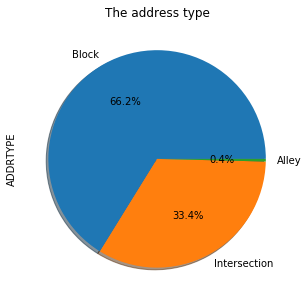

In [15]:
# ADDRTYPE
df.ADDRTYPE.value_counts().plot(kind='pie', figsize=(10,5), autopct='%1.1f%%', shadow = True, title = 'The address type')
plt.show()

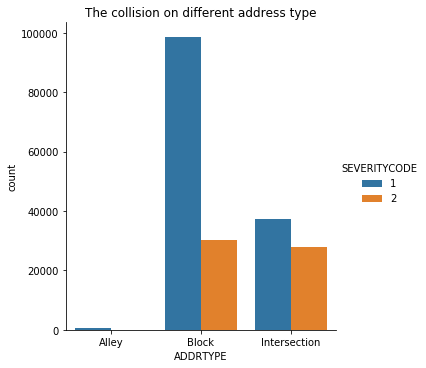

In [16]:
# ADDRTYPE and SEVERITYCODE
add_sev = df[['ADDRTYPE', 'SEVERITYCODE']]
add_sev_df = pd.DataFrame(add_sev.groupby(['ADDRTYPE', 'SEVERITYCODE']).size().reset_index(name='count'))
add_sev_plot = sns.catplot(x = 'ADDRTYPE',       # x variable name
            y = "count",       # y variable name
            hue = "SEVERITYCODE",  # group variable name
            data = add_sev_df,     # dataframe to plot
            kind = "bar")
add_sev_plot.set(title = 'The collision on different address type')


The collision occurred at block type of address the most and at the intersection the second-most. The collision rarely happened at the alley. For both severity codes, the collision occurred at the block more than at the intersection.

### 3.1.2 JUNCTIONTYPE

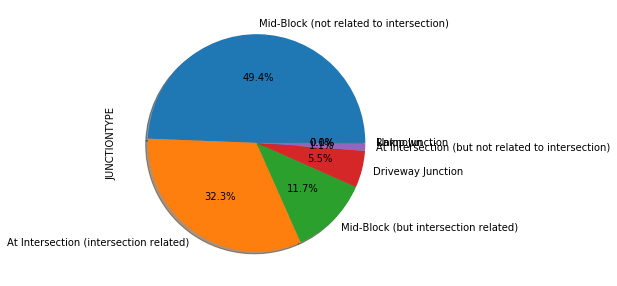

In [17]:
df.JUNCTIONTYPE.value_counts().plot(kind='pie', figsize=(10,5), autopct='%1.1f%%', shadow = True)

In terms of junction type, it is identified that the collisions occurred at mid-block (not related to intersection) the most frequently and at intersection (intersection related) the second-most frequently.

### 3.1.3. WEATHER

Text(0, 0.5, 'Count')

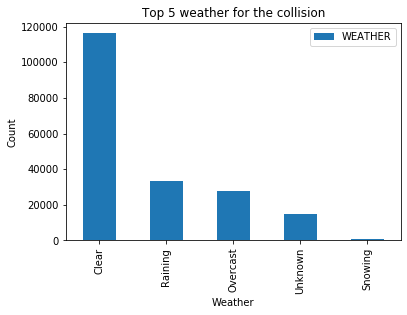

In [18]:
weather_count = pd.DataFrame(df.WEATHER.value_counts())
weather_count_top5 = weather_count.head(5)
weather_count_top5.plot.bar(title = 'Top 5 weather for the collision')
plt.xlabel('Weather')
plt.ylabel('Count')



Interestingly, when collision occurred, most of the weather was clear, and unexpectedly, raining and overcast were overwhelmingly low.

### 3.1.4. ROADCOND

Text(0, 0.5, 'Count')

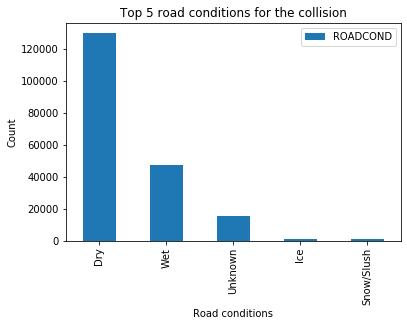

In [19]:
road_count = pd.DataFrame(df.ROADCOND.value_counts())
road_count_top5 = road_count.head(5)
road_count_top5.plot.bar(title = 'Top 5 road conditions for the collision')
plt.xlabel('Road conditions')
plt.ylabel('Count')

Top 5 road conditions were Dry, Wet, Unknown, Ice, Snow/Slush, and in most cases it can be seen that the road condition was dry.

### 3.1.5. LIGHTCOND

Text(0, 0.5, 'Count')

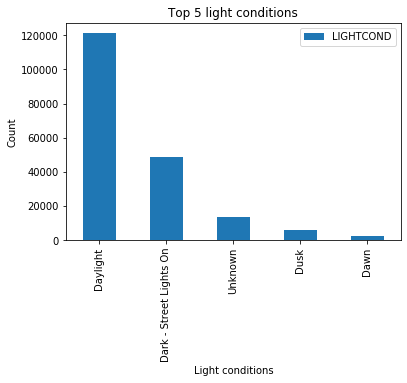

In [20]:
light_pd = pd.DataFrame(df.LIGHTCOND.value_counts()).head(5)
light_pd.plot.bar(title = 'Top 5 light conditions')
plt.xlabel('Light conditions')
plt.ylabel('Count')

For light condition, dark and dawn showed low number of cases, and daylight was the most common case. It can be assumed that most collisions occurred during the day.

### 3.1.6. SPEEDING

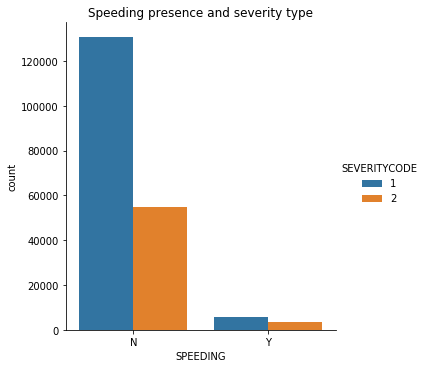

In [21]:
df.SPEEDING.value_counts()
spd_sev = df[['SPEEDING', 'SEVERITYCODE']]
spd_sev_df = pd.DataFrame(spd_sev.groupby(['SPEEDING', 'SEVERITYCODE']).size().reset_index(name='count'))
spd_sev_plot = sns.catplot(x = 'SPEEDING',       # x variable name
            y = "count",       # y variable name
            hue = "SEVERITYCODE",  # group variable name
            data = spd_sev_df,     # dataframe to plot
            kind = "bar")
spd_sev_plot.set(title = 'Speeding presence and severity type')


When there was a collision, a large percentage of drivers did not speed, and even when considering the two different severity types, the proportion of drivers of each severity type not speeding was much higher.

### 3.1.7. SEVERITYCODE

The distribution of the severity of collision shows there are only two types of collision appeared in dataset in terms of the severity. 

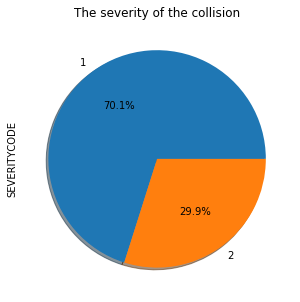

In [22]:
df.SEVERITYCODE.value_counts().plot(kind='pie', figsize=(10,5), autopct='%1.1f%%', shadow = True, title = 'The severity of the collision')
plt.show()

In [23]:
pd.DataFrame(df.SEVERITYCODE.value_counts())

,SEVERITYCODE
1,136485
2,58188


The severity of 1 (prop damage) with 70.1% occurred more than the severity of 2 (injury) with 29.9%. As this chart and count of severity code show, this dataset is imbalanced. This causes a biased ML model, so the dataset should be balanced before processing. 

To handle imbalanced data, there are two ways such as undersampling and oversampling. Oversampling may result in overfitting problem, so random undersampling method is used after splitting data into training and testing data in the machine learning process.


## 4. Methodoloy <a name="methodology"></a>

### 4.1. Balancing data in training data

Before starting machine learning modelling, separate the Y label which is SEVERITYCODE and we want to predict here from the dataset. Then, split the dataset into training and testing data at an 80:20 ratio.

In [24]:
X = df[['ADDRTYPE', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING']].values
y = df[['SEVERITYCODE']].values

In [25]:
# Divide the dataset by X and Y with 80:20.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [26]:
# Check 
print('The proportion of train data is', len(X_train)/(len(X_train)+len(X_test)), '.')
print('The proportion of test data is', len(X_test)/(len(X_train)+len(X_test)), '.')


The proportion of train data is 0.7999979452723285 .
The proportion of test data is 0.20000205472767152 .


The dataset is successfully splitted. Conduct undersampling the training data to prevent creating a biased model. 

By setting sampling strategy as majority, it will undersample the majority class which is the class with the largest number of examples. In this case, SEVERITYCODE 1 becomes the majority class having 135,485 examples (cases) in total dataset and SEVERITYCODE 2 becomes the minority class. 

It will be undersampled, so that both classes would have the same size of samples which is the sample size of the minority class. A balanced class distribution will be created by selecting majority class instances at random to be removed.

In [27]:
# Undersampling with majority sampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

# Check if undersampling is conducted successfully
collections.Counter(y_train)

Counter({1: 46677, 2: 46677})

### 4.2. Ordinal encoder

Now, it looks like the dataset is balanced. As selected attributes are categorical variables, they cannot be used directly in predictive modelling. In this case, those categorical variables should be encoded to numbers before fitting and evaluating a model. Use ordinal encoder to encode categorical variables to numbers.

In [28]:
# ordinal encode input variables
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train)
X_train = ordinal_encoder.transform(X_train)
X_test = ordinal_encoder.transform(X_test)

# ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### 4.3. Logistic regression

There are two types of models in predictive modelling which are classification and regression model. To build prediction models in this project which predict the severity of the collision, since all dependent variables are categorical variables, classification algorithms are considered for modelling. 

Three classification algorithms are selected such as logistic regression, decision tree and support vector machine and used to predict the severity of the collision. 

In [29]:
# Define the model
lr_model = LogisticRegression()

# Fit on the training set
lr_model.fit(X_train, y_train)

# Predict with test set
y_pred = lr_model.predict(X_test)

# Evaluate prediction accuracy
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:' , accuracy*100)

# Model Precision
prec = metrics.precision_score(y_test, y_pred)
print("Precision:", prec)

# Model Recall
recal = metrics.recall_score(y_test, y_pred)
print("Recall:", recal)

lr = [accuracy, prec, recal]

Accuracy: 62.58893026839605
Precision: 0.4058435554459718
Recall: 0.5719746329597776


### 4.4. Decision tree

In [30]:
# Define the model
dt_model = DecisionTreeClassifier()

# Fit on the training set
dt_model.fit(X_train, y_train)

# Predict with test set
y_pred = dt_model.predict(X_test)

# Evaluate prediction accuracy
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:' , accuracy*100)

# Model Precision
prec = metrics.precision_score(y_test, y_pred)
print("Precision:", prec)

# Model Recall
recal = metrics.recall_score(y_test, y_pred)
print("Recall:", recal)

dt = [accuracy, prec, recal]

Accuracy: 60.32618466675228
Precision: 0.397861739671995
Recall: 0.6659716792633134


### 4.5. Support Vector Machine (SVM)

In [31]:
from sklearn import metrics

# Create a SVM Classifier
svm_clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svm_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svm_clf.predict(X_test)

# Evaluate prediction accuracy
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:' , accuracy*100)

# Model Precision
prec = metrics.precision_score(y_test, y_pred)
print("Precision:", prec)

# Model Recall
recal = metrics.recall_score(y_test, y_pred)
print("Recall:", recal)

svm = [accuracy, prec, recal]

Accuracy: 62.262745601643765
Precision: 0.4039715113471753
Recall: 0.5814438363304665


## 5. Results & Discussion  <a name="results"></a>

Accuracy, precision and recall are calculated to meausre the performance of three models, 

In [32]:
accuracy_df = pd.DataFrame({"LR":lr, "DT": dt, "SVM":svm}, index = ['Accuracy', 'Precision', 'Recall'])
accuracy_df

,LR,DT,SVM
Accuracy,0.625889,0.603262,0.622627
Precision,0.405844,0.397862,0.403972
Recall,0.571975,0.665972,0.581444


To evaluate the performance of three models, accuracy, precision and recall are calculated to measure the performance of three models. Accuracy is calculated as the proportion of correctly predicted labels out of the total number of labels. It can be said that the higher the accuracy, the better. 

In terms of accuracy, all of three models give the accuracy of over 60%. Among them, logical regression showed the highest performance. SVM also showed similar performance. However, the accuracy of 60% cannot be said to be a very good accuracy.

## Concluision <a name = "conclusioin"></a>

To sum up, modelling was performed with only 7 columns of the existing 37 attributes. For unbalanced datasets, undersampling was used to balance the dataset to create a biased model. 

Since categorical variables were used for prediction, classification algorithms were used such as logistic regression, decision tree and support vector machine (SVM). Based on the performance with accuracy for each model, it is concluded that logistic regression and support vector machine is the best model for predicting the severity of the collisions among the three models used. 

However, the accuracy of 62% is not high enough for predictive modelling. Thus, it is recommended that different resampling methods and can be used to improve the accuracy and robustness over a single estimator. Furthermore, this project simply focused on prediction, but it would have been more helpful to find insights into which variables influence collisions more than just prediction.